# Libraries:

In [1]:
import os
import numpy as np
import scipy.io.wavfile as wav
import resampy
import matplotlib.pyplot as plt
from python_speech_features.sigproc import preemphasis, framesig, powspec
from python_speech_features.base import get_filterbanks
import pandas as pd

# Common settings and params:

In [2]:
os.chdir('C:/Users/User/Desktop/VegaVAD project/') # Working directory
REAL_DIR = 'data/real/'
FILENAME = 'room.wav'
OUTPUT_FILENAME_FOR_BILSTM = 'data/real_BILSTM.csv'
OUTPUT_FILENAME_FOR_CNN_BILSTM = 'data/real_CNN_BILSTM.csv'

SAMPLE_RATE = 16000

# Pre-emphasis:
PREEMPHASIS_COEFF = 0.97 # Coefficient for pre-processing filter

# Framing:
FRAME_LENGTH = 0.025 # Window length in sec
FRAME_STEP = 0.01 # Length of step in sec
WINDOW_FUNCTION = np.hamming  # Type of window function

# Power spectrum:
N_FFT = 512 # Points of FFT

# Filter banks:
N_FEATURES = 32 # Number of Mel filters

# Size of image:
N_FRAMES = 32 # Number of frames for uniting in image

# Construct pipepline:

In next sections we will build the pipeline of converting audio file in features for ML model in details.
Below is shown steps of pipeline:
1. Audio convertor
2. Pre-emphasis for signal
3. Framing signal
4. Power spectrum
5. Calculate the energy on frame
6. Filter banks
7. Get fbanks (features)
8. Log fbanks and energy
9. Combine log fbanks and log energy
10. Reshape log fbanks into images (for <b>*CNN-BiLSTM*</b>)
11. Write features in to file

## 1. Audio convertor:

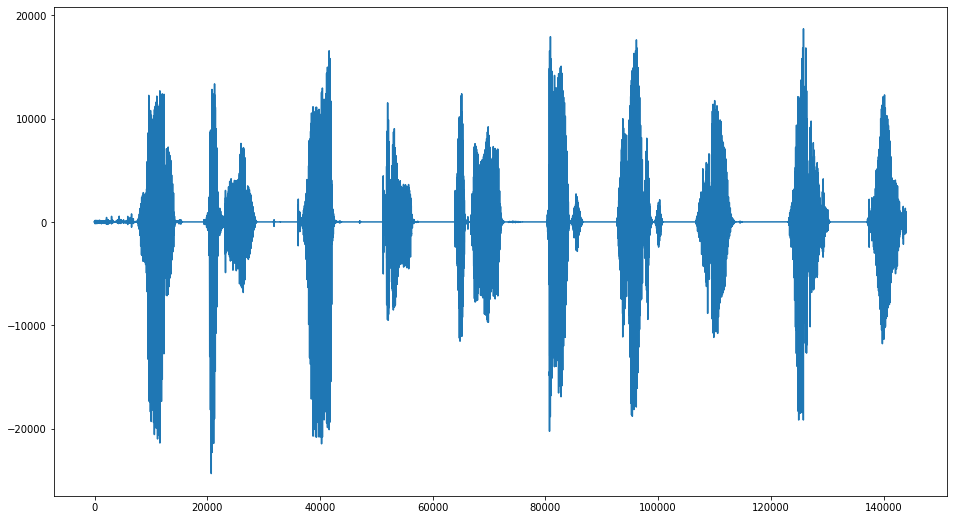

In [3]:
(rate, sig) = wav.read(REAL_DIR+FILENAME)
sig = resampy.resample(x=sig, sr_orig=rate, sr_new=SAMPLE_RATE)
plt.figure(figsize=(16, 9))
plt.plot(sig)

In [4]:
sig

array([  72,   93,   21, ..., -159, -134,  302], dtype=int16)

## 2. Pre-emphasis:

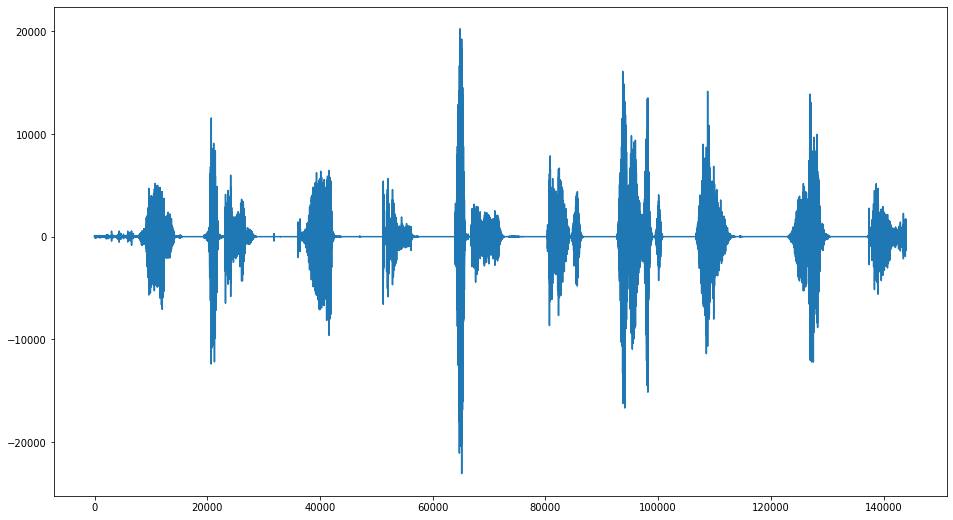

In [5]:
preemhasis_sig = preemphasis(sig, coeff=PREEMPHASIS_COEFF)
plt.figure(figsize=(16, 9))
plt.plot(preemhasis_sig)

In [6]:
preemhasis_sig

array([  72.  ,   23.16,  -69.21, ..., -273.46,   20.23,  431.98])

## 3. Framing:

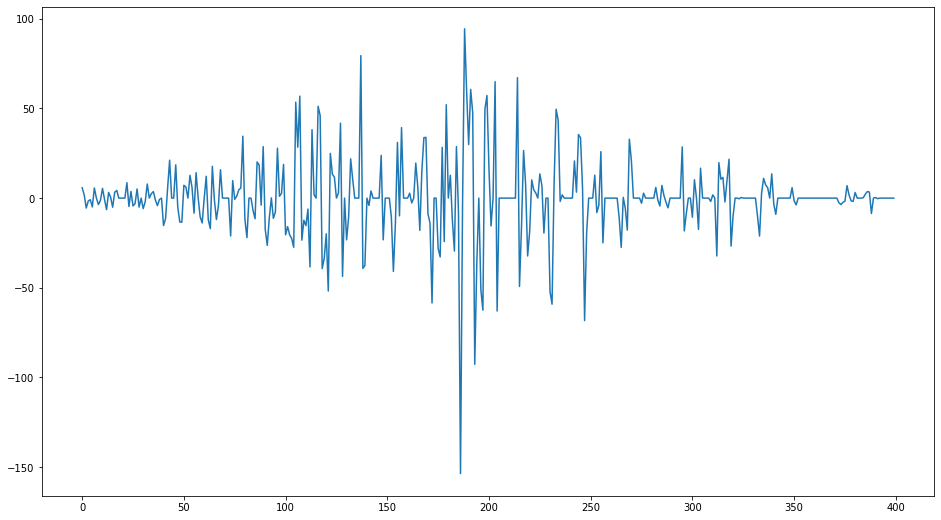

In [7]:
frames = framesig(preemhasis_sig, frame_len=FRAME_LENGTH * SAMPLE_RATE, frame_step=FRAME_STEP * SAMPLE_RATE, winfunc=WINDOW_FUNCTION)
plt.figure(figsize=(16, 9))
plt.plot(frames[0])

In [8]:
frames

array([[  5.76      ,   1.8541209 ,  -5.55258828, ...,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.2401711 ,  -0.23346383, ...,  -1.0421633 ,
          3.25431843,   0.2328    ],
       [ -2.0176    ,   0.        ,   0.        , ...,   2.48707176,
         -2.40731501,   0.        ],
       ...,
       [ -3.36      ,   3.26152356,   7.30075904, ...,   7.00391499,
         40.02851693, -35.12      ],
       [ 16.268     ,  -4.63209998, -22.87143283, ...,  12.63512683,
        -96.54477999,  69.2456    ],
       [ 19.2968    , -32.55519282,   0.78944471, ...,   0.        ,
          0.        ,   0.        ]])

## 4. Power spectrum:

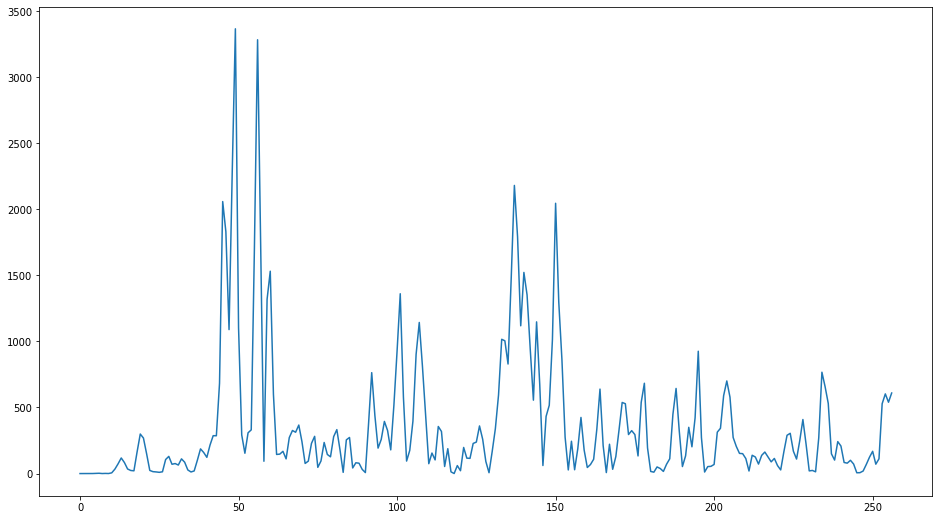

In [9]:
pow_spec = powspec(frames, NFFT=N_FFT)
plt.figure(figsize=(16, 9))
plt.plot(pow_spec[0])

In [10]:
pow_spec

array([[5.48226636e-02, 4.25698849e-02, 5.08808554e-02, ...,
        6.02750210e+02, 5.39663657e+02, 6.09365643e+02],
       [1.98414438e-01, 2.68134261e-01, 1.99231189e-01, ...,
        1.21021781e+01, 3.33934164e+00, 2.27305843e+01],
       [1.41430493e-02, 1.68192699e-01, 3.59033049e-01, ...,
        2.72161083e+01, 3.99138924e+01, 2.36980387e+01],
       ...,
       [8.60830461e-01, 5.03703993e-01, 1.89955665e+00, ...,
        2.36141737e+02, 2.01507291e+02, 5.74194845e+01],
       [2.24106951e+00, 1.76898114e+00, 1.51564569e+00, ...,
        4.87589405e+02, 3.07875144e+02, 9.94420193e+02],
       [1.51294454e+01, 2.25386656e+01, 2.58770971e+01, ...,
        3.06792289e+03, 5.65088683e+02, 2.06531310e+02]])

## 5. Energy on frame:

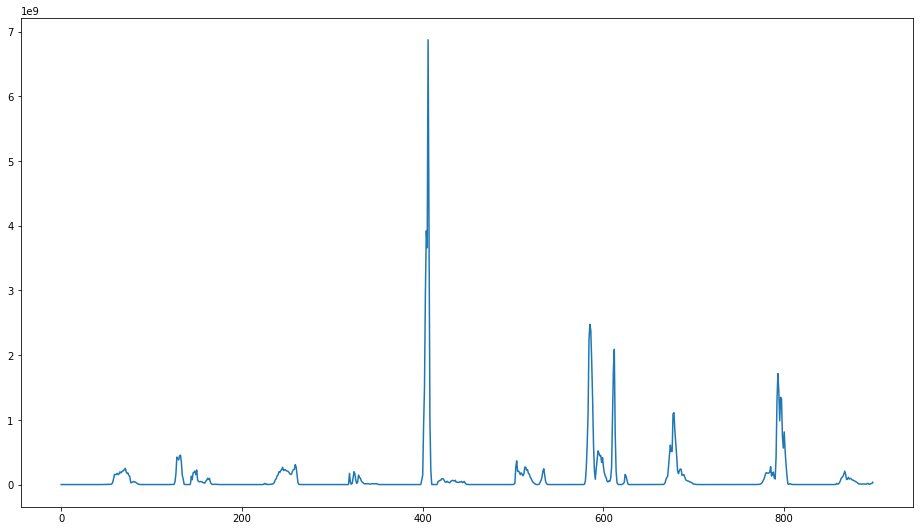

In [11]:
energy = np.sum(pow_spec, 1) # This stores the total energy in each frame
energy = np.where(energy == 0, np.finfo(float).eps, energy) # If energy is zero, we get problems with log
plt.figure(figsize=(16, 9))
plt.plot(energy)

In [12]:
energy

array([9.21647971e+04, 5.41905652e+04, 4.80396348e+04, 3.52790029e+04,
       6.24368287e+04, 5.92432187e+04, 3.02710480e+04, 4.32065793e+04,
       2.17050601e+04, 4.16551266e+04, 4.02709688e+04, 5.21994095e+04,
       2.37910525e+05, 1.89101132e+05, 1.68949436e+05, 5.33260780e+04,
       1.24704392e+04, 9.11040643e+04, 2.15063146e+05, 3.62173946e+04,
       1.03987621e+04, 3.03006752e+03, 4.25460696e+03, 1.62439225e+04,
       9.47047367e+04, 9.98328944e+04, 3.78100831e+05, 5.20205230e+04,
       1.45247870e+05, 7.37156210e+03, 1.62510514e+04, 7.21188796e+04,
       1.22605350e+04, 2.36366363e+04, 4.25835958e+04, 1.89914560e+05,
       2.72864446e+05, 5.12545225e+04, 2.41681041e+05, 1.75814779e+05,
       8.08081741e+05, 3.68486412e+04, 1.07455323e+05, 7.91986286e+03,
       2.48026934e+03, 9.78744185e+03, 1.49297752e+04, 5.30503027e+04,
       2.24010091e+05, 7.37797015e+05, 1.71571921e+06, 2.86920610e+06,
       3.35391302e+06, 3.62096414e+06, 3.87362417e+06, 4.56706070e+06,
      

## 6. Filter banks:

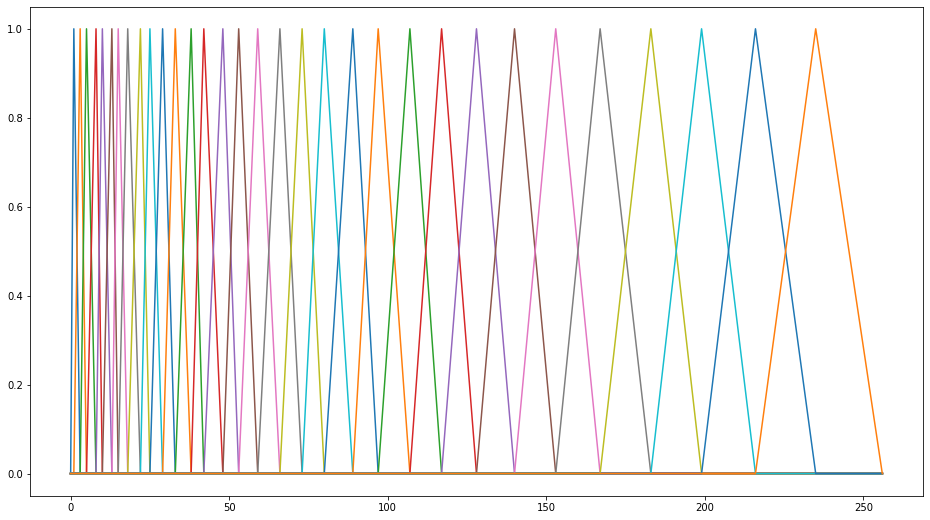

In [13]:
fb = get_filterbanks(nfilt=N_FEATURES, nfft=N_FFT, samplerate=SAMPLE_RATE)
plt.figure(figsize=(16, 9))
for i in range(fb.shape[0]):
    plt.plot(fb[i])

In [14]:
fb

array([[0.        , 1.        , 0.5       , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.5       , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.0952381 , 0.04761905,
        0.        ]])

## 7. Get fbanks:

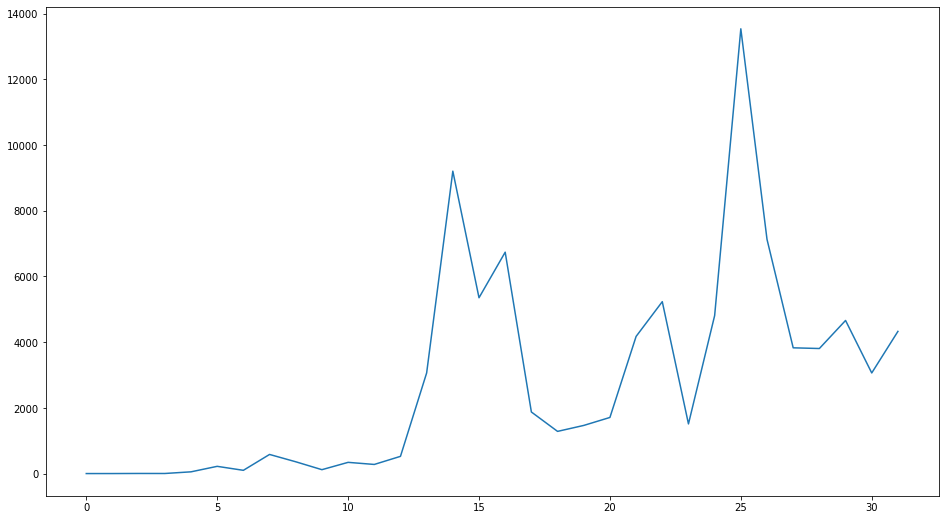

In [15]:
feat = np.dot(pow_spec, fb.T) # Compute the filterbank energies
feat = np.where(feat == 0, np.finfo(float).eps, feat) # If feat is zero, we get problems with log
plt.figure(figsize=(16, 9))
plt.plot(feat[0])

In [16]:
feat

array([[6.80103126e-02, 4.50109104e-01, 3.13318306e+00, ...,
        4.66131170e+03, 3.06294471e+03, 4.32861624e+03],
       [3.67749856e-01, 1.49731124e-01, 2.13890087e+00, ...,
        1.81706426e+03, 4.14481140e+03, 2.42288150e+03],
       [3.47709223e-01, 5.92924430e-01, 5.96433415e+00, ...,
        2.40476408e+03, 3.27151817e+03, 2.25122209e+03],
       ...,
       [1.45348232e+00, 1.88337539e+01, 7.82848917e+03, ...,
        1.64502252e+06, 6.78395032e+05, 1.25011087e+05],
       [2.52680398e+00, 4.98522907e+00, 1.98419078e+03, ...,
        1.88766584e+06, 4.70244620e+05, 1.16981787e+05],
       [3.54772142e+01, 8.50072455e+01, 7.49498624e+02, ...,
        8.51396471e+06, 1.00263819e+06, 3.43906996e+05]])

## 8. Log fbanks and energy:

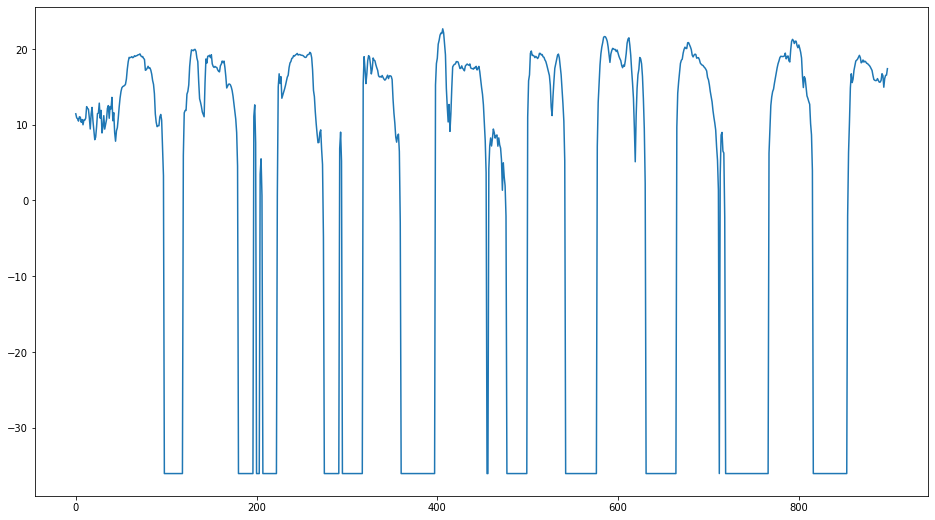

In [17]:
log_energy = np.log(energy)
log_feat = np.log(feat)
plt.figure(figsize=(16, 9))
plt.plot(log_energy)

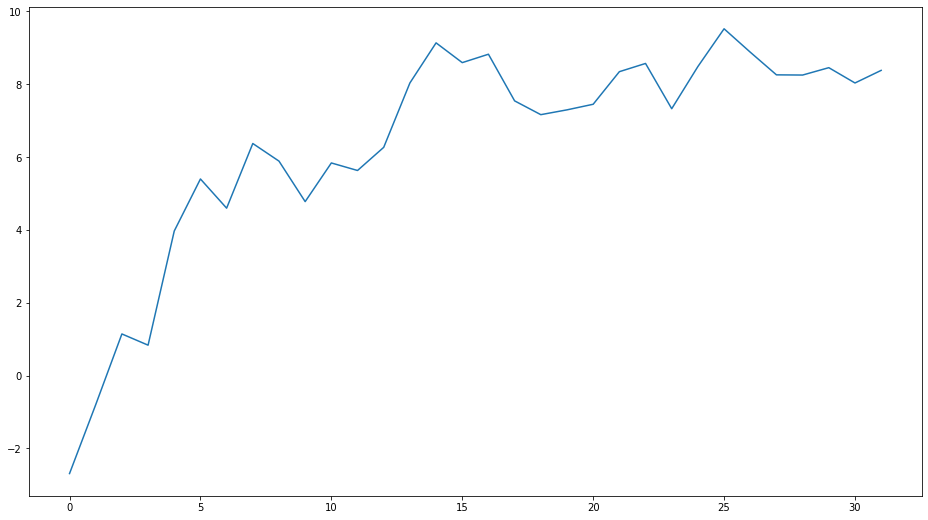

In [18]:
plt.figure(figsize=(16, 9))
plt.plot(log_feat[0])

In [19]:
log_energy

array([ 11.43133353,  10.9002621 ,  10.77978167,  10.47104325,
        11.04191058,  10.9894066 ,  10.31794702,  10.67374806,
         9.9853007 ,  10.63717973,  10.60338611,  10.86282646,
        12.37964994,  12.15003724,  12.03735476,  10.88418076,
         9.43111626,  11.4197577 ,  12.27868697,  10.4972948 ,
         9.24944205,   8.01634018,   8.35575766,   9.69547411,
        11.4585193 ,  11.51125301,  12.84291619,  10.85939359,
        11.88619701,   8.90538492,   9.69591289,  11.18607114,
         9.41414085,  10.07055317,  10.65922438,  12.15432957,
        12.51673042,  10.84455914,  12.39537412,  12.07718633,
        13.6024185 ,  10.51457402,  11.58483044,   8.97712917,
         7.81612244,   9.1888554 ,   9.61111283,  10.87899585,
        12.31944638,  13.51142402,  14.35534291,  14.86954593,
        15.02563829,  15.10225088,  15.1697011 ,  15.33438038,
        16.02124596,  17.33636944,  18.29846875,  18.87507323,
        18.84262752,  18.88287324,  18.97545365,  18.83

In [20]:
log_feat

array([[-2.68809593, -0.79826527,  1.14204944, ...,  8.44705217,
         8.02713206,  8.3730032 ],
       [-1.00035231, -1.8989141 ,  0.76029209, ...,  7.50497743,
         8.32961257,  7.79271282],
       [-1.05638871, -0.52268832,  1.78579742, ...,  7.78520708,
         8.09300943,  7.7192285 ],
       ...,
       [ 0.37396228,  2.93565068,  8.96552482, ..., 14.31326463,
        13.42748504, 11.73615771],
       [ 0.92695526,  1.60647935,  7.59296644, ..., 14.45085162,
        13.06100831, 11.66977353],
       [ 3.56889064,  4.44273649,  6.61940448, ..., 15.95721828,
        13.81814528, 12.74812654]])

## 9. Combine log fbanks and log energy:

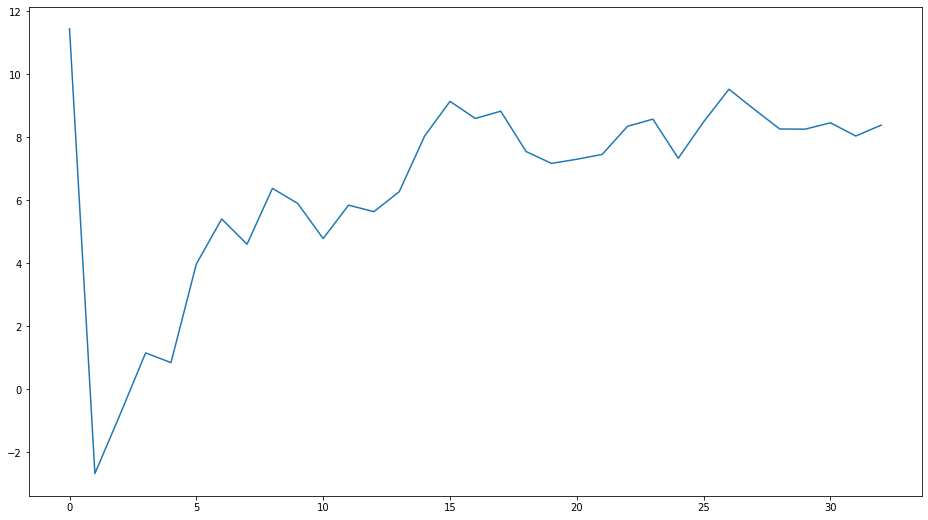

In [21]:
features = np.zeros((log_feat.shape[0], log_feat.shape[1] + 1))
features[:, 0] = log_energy
features[:, 1:] = log_feat
plt.figure(figsize=(16, 9))
plt.plot(features[0])

In [22]:
features

array([[11.43133353, -2.68809593, -0.79826527, ...,  8.44705217,
         8.02713206,  8.3730032 ],
       [10.9002621 , -1.00035231, -1.8989141 , ...,  7.50497743,
         8.32961257,  7.79271282],
       [10.77978167, -1.05638871, -0.52268832, ...,  7.78520708,
         8.09300943,  7.7192285 ],
       ...,
       [16.51214389,  0.37396228,  2.93565068, ..., 14.31326463,
        13.42748504, 11.73615771],
       [16.54320312,  0.92695526,  1.60647935, ..., 14.45085162,
        13.06100831, 11.66977353],
       [17.38982161,  3.56889064,  4.44273649, ..., 15.95721828,
        13.81814528, 12.74812654]])

## 10. Reshape log fbanks into images (for <b>*CNN-BiLSTM*</b>):

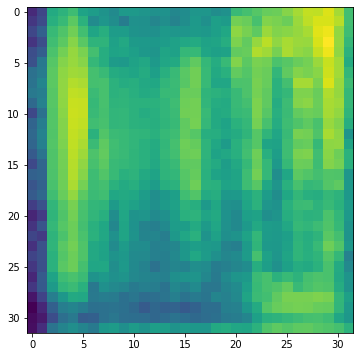

In [23]:
features_images = list()
for i in range(int(np.floor(log_feat.shape[0] / N_FRAMES))):
    spectrogram_image = log_feat[i * N_FRAMES:(i + 1) * N_FRAMES]
    spectrogram_image_in_line = spectrogram_image.reshape(N_FRAMES * N_FRAMES)
    features_images.append(spectrogram_image_in_line)
plt.figure(figsize=(6, 6))
plt.imshow(spectrogram_image)

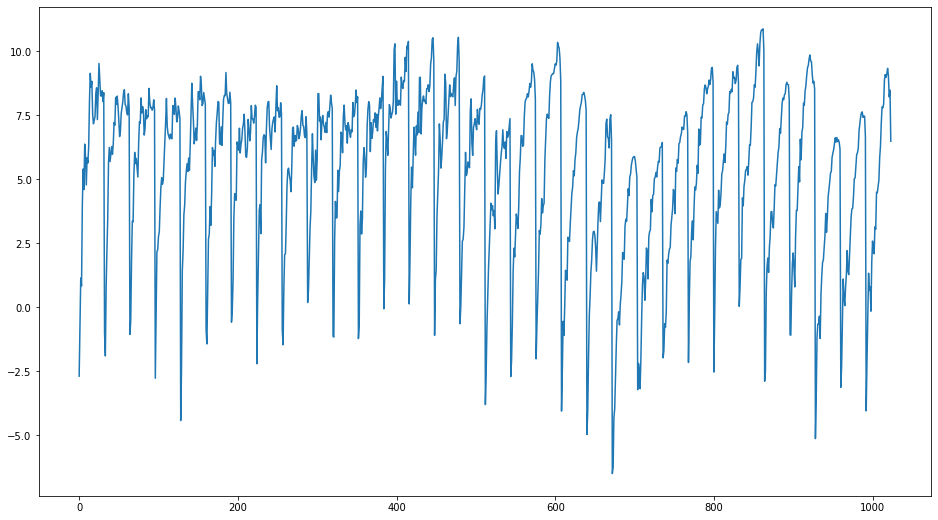

In [24]:
features_images = np.array(features_images)
plt.figure(figsize=(16, 9))
plt.plot(features_images[0])

In [25]:
features_images

array([[ -2.68809593,  -0.79826527,   1.14204944, ...,   8.21119245,
          8.47115624,   6.47763792],
       [ -2.82881265,  -1.19470773,  -0.46574537, ...,  13.99740435,
         13.96868212,  12.90687582],
       [  4.71929708,   7.53614546,  12.97608233, ...,   8.24334915,
          8.23022579,   7.9654399 ],
       ...,
       [  5.2254297 ,   5.32166601,   6.18760538, ..., -36.04365339,
        -36.04365339, -36.04365339],
       [-36.04365339, -36.04365339, -36.04365339, ...,  17.55453649,
         16.29708316,  12.11449119],
       [  3.24137152,   4.78135591,  11.71940815, ...,  13.63934497,
         13.32233593,  12.27233544]])

## 11. Write features in to file:

In [26]:
features_1 = pd.DataFrame(features)
features_2 = pd.DataFrame(features_images)
features_1.to_csv(OUTPUT_FILENAME_FOR_BILSTM, header=False, index=False)
features_2.to_csv(OUTPUT_FILENAME_FOR_CNN_BILSTM, header=False, index=False)